In [3]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

In [4]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/train.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/test.csv')

train = data1.copy()
test = data2.copy()

submission_df = data2.copy()
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [5]:
train = train.fillna(train.median(numeric_only= True))
test = test.fillna(test.median(numeric_only= True))

In [6]:
from my_functions import lower_case

lower_case(train, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment', 'Listening_Time_minutes'])

lower_case(test, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment'])

In [7]:
days_encoding = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

train['weekday_encoded'] = train['publication_day'].map(days_encoding)

test['weekday_encoded'] = test['publication_day'].map(days_encoding)

publication_encoding = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 4
}

train['publication_encoded'] = train['publication_time'].map(publication_encoding)

test['publication_encoded'] = test['publication_time'].map(publication_encoding)

train = train.drop(columns=['publication_day', 'publication_time'])

test = test.drop(columns=['publication_day', 'publication_time'])

print("Train df after encoding of day and time: \n", train.head(3))
print("Test df after encoding of day and time: \n", test.head(3))

Train df after encoding of day and time: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

  episode_sentiment  listening_time_minutes  weekday_encoded  \
0          Positive                31.41998                4   
1          Negative                88.01241                6   
2          Negative                44.92531                2   

   publication_encoded  
0                    4  
1                    1  
2          

In [8]:
episode_mapping = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

train['episode_sentiment_encoded'] = train['episode_sentiment'].map(episode_mapping)
test['episode_sentiment_encoded'] = test['episode_sentiment'].map(episode_mapping)

train = train.drop(columns='episode_sentiment')
test = test.drop(columns='episode_sentiment')

print("Train df after encoding the sentiment: \n", train.head(3))
print("Test df after encoding the sentiment: \n", test.head(3))

Train df after encoding the sentiment: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

   listening_time_minutes  weekday_encoded  publication_encoded  \
0                31.41998                4                    4   
1                88.01241                6                    1   
2                44.92531                2                    2   

   episode_sentiment_encoded  
0                          1  
1             

In [9]:
train = train.drop(columns=['id','podcast_name', 'episode_title', 'genre'])
test = test.drop(columns=['id','podcast_name', 'episode_title', 'genre'])

In [10]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,1,31.41998
1,119.80,66.95,75.95,2.0,6,1,-1,88.01241
2,73.90,69.97,8.97,0.0,2,2,-1,44.92531
3,67.17,57.22,78.70,2.0,1,0,1,46.27824
4,110.51,80.07,58.68,3.0,1,1,0,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,-1,56.87058
749996,75.75,35.21,53.58,2.0,6,4,0,45.46242
749997,30.98,78.58,84.89,0.0,4,0,-1,15.26000
749998,108.98,45.39,93.27,0.0,4,0,-1,100.72939


In [11]:
train['combined_popularity'] = (train['host_popularity_percentage'] / 100.0) * (train['guest_popularity_percentage'] / 100.0) *100.0
test['combined_popularity'] = (test['host_popularity_percentage'] / 100.0) * (test['guest_popularity_percentage'] / 100.0) *100.0

train['popularity_difference'] = (train['host_popularity_percentage'] - train['guest_popularity_percentage'])
test['popularity_difference'] = (test['host_popularity_percentage'] - test['guest_popularity_percentage'])

print("Train df after creation of 2 new features: \n", train.head(3))
print("Test df after creation of 2 new features: \n", test.head(3))

Train df after creation of 2 new features: 
    episode_length_minutes  host_popularity_percentage  \
0                   63.84                       74.81   
1                  119.80                       66.95   
2                   73.90                       69.97   

   guest_popularity_percentage  number_of_ads  weekday_encoded  \
0                        53.58            0.0                4   
1                        75.95            2.0                6   
2                         8.97            0.0                2   

   publication_encoded  episode_sentiment_encoded  listening_time_minutes  \
0                    4                          1                31.41998   
1                    1                         -1                88.01241   
2                    2                         -1                44.92531   

   combined_popularity  popularity_difference  
0            40.083198                  21.23  
1            50.848525                  -9.00  
2       

In [12]:
weekend_days = [6, 7]

train['is_weekend'] = train['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)
test['is_weekend'] = test['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)

In [13]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,1,40.083198,21.23,0,31.41998
1,119.80,66.95,75.95,2.0,6,1,-1,50.848525,-9.00,1,88.01241
2,73.90,69.97,8.97,0.0,2,2,-1,6.276309,61.00,0,44.92531
3,67.17,57.22,78.70,2.0,1,0,1,45.032140,-21.48,0,46.27824
4,110.51,80.07,58.68,3.0,1,1,0,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,-1,37.163088,15.78,1,56.87058
749996,75.75,35.21,53.58,2.0,6,4,0,18.865518,-18.37,1,45.46242
749997,30.98,78.58,84.89,0.0,4,0,-1,66.706562,-6.31,0,15.26000
749998,108.98,45.39,93.27,0.0,4,0,-1,42.335253,-47.88,0,100.72939


In [14]:
train = train.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])
test = test.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])

train

,episode_length_minutes,number_of_ads,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,0.0,4,1,40.083198,21.23,0,31.41998
1,119.80,2.0,1,-1,50.848525,-9.00,1,88.01241
2,73.90,0.0,2,-1,6.276309,61.00,0,44.92531
3,67.17,2.0,0,1,45.032140,-21.48,0,46.27824
4,110.51,3.0,1,0,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,0.0,0,-1,37.163088,15.78,1,56.87058
749996,75.75,2.0,4,0,18.865518,-18.37,1,45.46242
749997,30.98,0.0,0,-1,66.706562,-6.31,0,15.26000
749998,108.98,0.0,0,-1,42.335253,-47.88,0,100.72939


In [15]:
train['popularity_difference'] = abs(train['popularity_difference'])
test['popularity_difference'] = abs(test['popularity_difference'])

train['ad_density'] = train['number_of_ads'] / (train['episode_length_minutes'] + 0.1)
test['ad_density'] = test['number_of_ads'] / (train['episode_length_minutes'] + 0.1)




In [16]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

In [17]:
train = train.drop(columns=['number_of_ads', 'combined_popularity'])
test = test.drop(columns=['number_of_ads', 'combined_popularity'])

In [18]:
train['KPI_met'] = train.apply(
    lambda row: 1 if (row['listening_time_minutes'] / row['episode_length_minutes'] * 100) > 85.0 else 0,
    axis=1
)

train

,episode_length_minutes,publication_encoded,episode_sentiment_encoded,popularity_difference,is_weekend,ad_density,listening_time_minutes,KPI_met
0,63.84,4,1,21.23,0,0.000000,31.41998,0
1,119.80,1,-1,9.00,1,0.016681,88.01241,0
2,73.90,2,-1,61.00,0,0.000000,44.92531,0
3,67.17,0,1,21.48,0,0.029731,46.27824,0
4,110.51,1,0,21.39,0,0.027122,75.61031,0
...,...,...,...,...,...,...,...,...
749995,75.66,0,-1,15.78,1,0.000000,56.87058,0
749996,75.75,4,0,18.37,1,0.026368,45.46242,0
749997,30.98,0,-1,6.31,0,0.000000,15.26000,0
749998,108.98,0,-1,47.88,0,0.000000,100.72939,1


In [19]:
train['episode_length_label'] = train.apply(
    lambda row: 'Short' if row['episode_length_minutes'] < 39.0
    else 'Medium' if 39.0 <= row['episode_length_minutes'] < 63.0
    else 'Long' if 63.0 <= row['episode_length_minutes'] < 90.0
    else 'Extreme',
    axis=1
)

train

,episode_length_minutes,publication_encoded,episode_sentiment_encoded,popularity_difference,is_weekend,ad_density,listening_time_minutes,KPI_met,episode_length_label
0,63.84,4,1,21.23,0,0.000000,31.41998,0,Long
1,119.80,1,-1,9.00,1,0.016681,88.01241,0,Extreme
2,73.90,2,-1,61.00,0,0.000000,44.92531,0,Long
3,67.17,0,1,21.48,0,0.029731,46.27824,0,Long
4,110.51,1,0,21.39,0,0.027122,75.61031,0,Extreme
...,...,...,...,...,...,...,...,...,...
749995,75.66,0,-1,15.78,1,0.000000,56.87058,0,Long
749996,75.75,4,0,18.37,1,0.026368,45.46242,0,Long
749997,30.98,0,-1,6.31,0,0.000000,15.26000,0,Short
749998,108.98,0,-1,47.88,0,0.000000,100.72939,1,Extreme


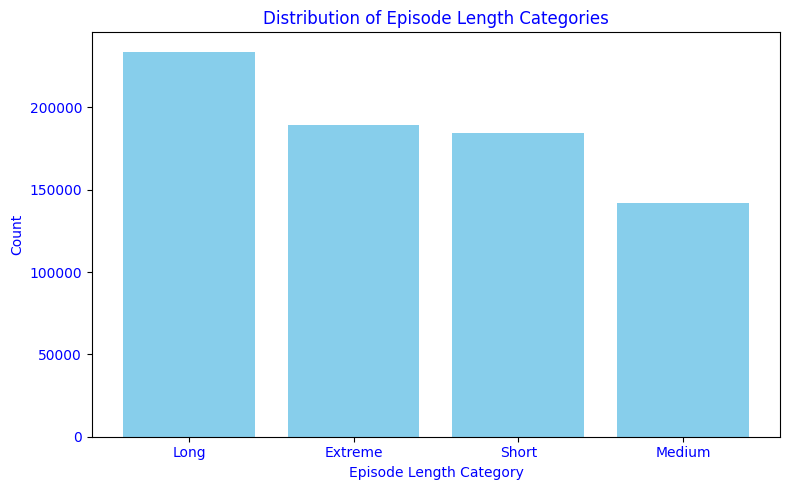

In [20]:
# Count the values
value_counts = train['episode_length_label'].value_counts()

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(value_counts.index, value_counts.values, color='skyblue')

# Axis labels
plt.xlabel('Episode Length Category', color='blue')
plt.ylabel('Count', color='blue')
plt.title('Distribution of Episode Length Categories', color='blue')

# Ticks color
plt.xticks(color='blue')
plt.yticks(color='blue')

# Show plot
plt.tight_layout()
plt.show()

In [21]:
def count_decimal_digits(s):
    if pd.isna(s):
        return None
    s = f"{s:.10f}".rstrip('0')  # limit to 10 decimals and strip trailing zeros
    if '.' in s:
        return len(s.split('.')[1])
    return 0

In [22]:
train['decimal_digits'] = train['episode_length_minutes'].apply(count_decimal_digits)
train_filtered = train[train['decimal_digits'] <= 2].drop(columns='decimal_digits')

In [23]:
train_filtered['decimal_digits'] = train['episode_length_minutes'].apply(count_decimal_digits)

train_filtered

,episode_length_minutes,publication_encoded,episode_sentiment_encoded,popularity_difference,is_weekend,ad_density,listening_time_minutes,KPI_met,episode_length_label,decimal_digits
0,63.84,4,1,21.23,0,0.000000,31.41998,0,Long,2
1,119.80,1,-1,9.00,1,0.016681,88.01241,0,Extreme,1
2,73.90,2,-1,61.00,0,0.000000,44.92531,0,Long,1
3,67.17,0,1,21.48,0,0.029731,46.27824,0,Long,2
4,110.51,1,0,21.39,0,0.027122,75.61031,0,Extreme,2
...,...,...,...,...,...,...,...,...,...,...
749995,75.66,0,-1,15.78,1,0.000000,56.87058,0,Long,2
749996,75.75,4,0,18.37,1,0.026368,45.46242,0,Long,2
749997,30.98,0,-1,6.31,0,0.000000,15.26000,0,Short,2
749998,108.98,0,-1,47.88,0,0.000000,100.72939,1,Extreme,2


In [24]:
train_filtered['decimal_digits'].value_counts()

decimal_digits
2    694108
1     49195
0      5413
Name: count, dtype: int64

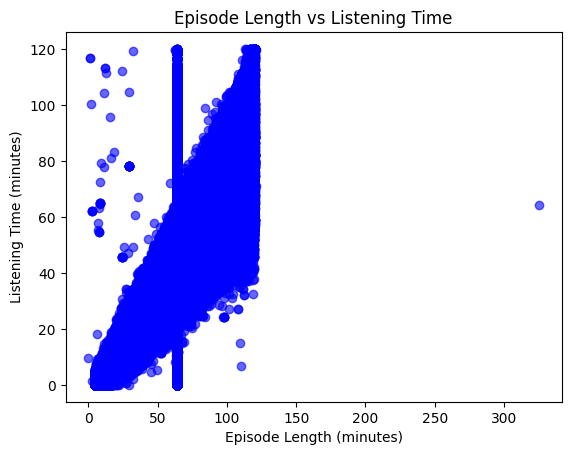

In [25]:
fig, ax = plt.subplots()
ax.scatter(
    train_filtered['episode_length_minutes'], train_filtered['listening_time_minutes'],
    marker='o',
    color='blue',
    alpha=0.6
)
ax.set_xlabel('Episode Length (minutes)')
ax.set_ylabel('Listening Time (minutes)')
ax.set_title('Episode Length vs Listening Time')
plt.show()

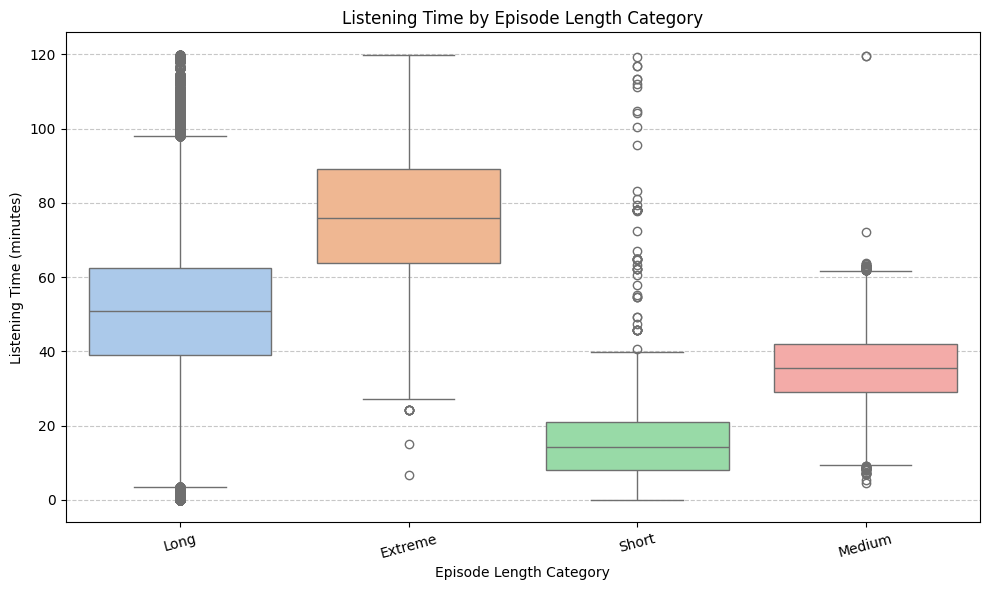

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='episode_length_label',
    y='listening_time_minutes',
    data=train_filtered,
    palette='pastel'
)
plt.title('Listening Time by Episode Length Category')
plt.xlabel('Episode Length Category')
plt.ylabel('Listening Time (minutes)')
plt.xticks(rotation=15)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
def remove_outliers_by_group(df, feature, group_col):
    def iqr_filter(group):
        Q1 = group[feature].quantile(0.25)
        Q3 = group[feature].quantile(0.75)
        IQR = Q3 - Q1
        return group[(group[feature] >= Q1 - 1.5 * IQR) & (group[feature] <= Q3 + 1.5 * IQR)]

    return df.groupby(group_col, group_keys=False).apply(iqr_filter)

#removing outliers
train_filtered = remove_outliers_by_group(train_filtered, 'listening_time_minutes', 'episode_length_label')


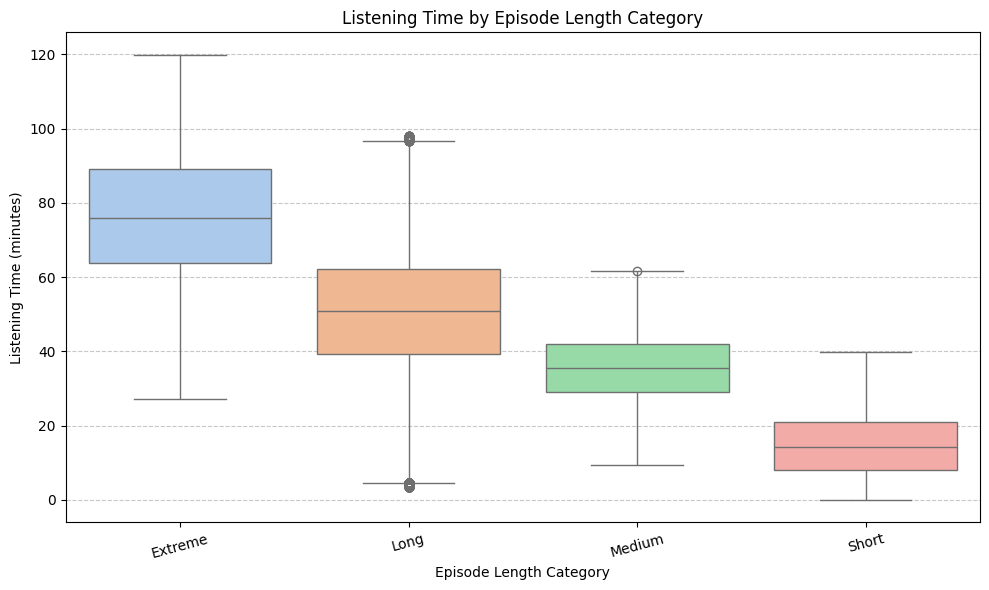

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='episode_length_label',
    y='listening_time_minutes',
    data=train_filtered,
    palette='pastel'
)
plt.title('Listening Time by Episode Length Category')
plt.xlabel('Episode Length Category')
plt.ylabel('Listening Time (minutes)')
plt.xticks(rotation=15)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
train_filtered

,episode_length_minutes,publication_encoded,episode_sentiment_encoded,popularity_difference,is_weekend,ad_density,listening_time_minutes,KPI_met,episode_length_label,decimal_digits
1,119.80,1,-1,9.00,1,0.016681,88.01241,0,Extreme,1
4,110.51,1,0,21.39,0,0.027122,75.61031,0,Extreme,2
8,105.87,2,0,16.23,0,0.018873,68.00124,0,Extreme,2
10,106.41,2,1,51.45,0,0.028166,74.08016,0,Extreme,2
11,107.26,2,1,0.00,0,0.009314,103.56000,1,Extreme,2
...,...,...,...,...,...,...,...,...,...,...
749988,18.08,4,0,30.41,0,0.055006,9.91916,0,Short,2
749993,23.52,2,0,48.03,0,0.000000,19.71374,0,Short,2
749994,8.93,2,0,31.94,1,0.110742,7.39878,0,Short,2
749997,30.98,0,-1,6.31,0,0.000000,15.26000,0,Short,2


In [30]:
train_filtered = train_filtered.drop(columns=['episode_length_label', 'decimal_digits', 'KPI_met'])

In [31]:
from sklearn.model_selection import train_test_split

X = train_filtered.drop(columns='listening_time_minutes')
y = train_filtered['listening_time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

In [32]:
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Linear Regression" : LinearRegression(),
        "Random Forest" : RandomForestRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df, model

In [33]:
import pickle

results_df, final_model = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

# Saving the model to a file
# with open('xgb_cleaned_out.pkl', 'wb') as file:
#     pickle.dump(final_model, file)

# print("Model saved successfully to 'xgb_cleaned_out.pkl'")

Starting the training process.
Training model: Linear Regression
Training model: Random Forest
Training model: XGB

Model Performance Summary:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.681335  9.626826   12.934996  12.883016  0.769058   
1      Random Forest   3.572080  9.360903    5.232683  13.183783  0.962206   
2                XGB   9.286884  9.336749   12.493935  12.596893  0.784539   

    Test R2  
0  0.770041  
1  0.759178  
2  0.780142  
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.681335  9.626826   12.934996  12.883016  0.769058   
1      Random Forest   3.572080  9.360903    5.232683  13.183783  0.962206   
2                XGB   9.286884  9.336749   12.493935  12.596893  0.784539   

    Test R2  
0  0.770041  
1  0.759178  
2  0.780142  


In [35]:
submission_df = data2.copy()

submission_df = submission_df.fillna(test.median(numeric_only= True))

lower_case(submission_df, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment'])

days_encoding = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}


submission_df['weekday_encoded'] = submission_df['publication_day'].map(days_encoding)

publication_encoding = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 4
}

submission_df['publication_encoded'] = submission_df['publication_time'].map(publication_encoding)

submission_df = submission_df.drop(columns=['publication_day', 'publication_time'])

episode_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

submission_df['episode_sentiment_encoded'] = submission_df['episode_sentiment'].map(episode_mapping)

submission_df = submission_df.drop(columns='episode_sentiment')

submission_df = submission_df.drop(columns=['podcast_name', 'episode_title', 'genre'])

submission_df['combined_popularity'] = (submission_df['host_popularity_percentage'] / 100.0) * (submission_df['guest_popularity_percentage'] / 100.0) *100.0

submission_df['popularity_difference'] = (submission_df['host_popularity_percentage'] - submission_df['guest_popularity_percentage'])

weekend_days = [6, 7]

submission_df['is_weekend'] = submission_df['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)

submission_df = submission_df.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])

submission_df['ad_density'] = submission_df['number_of_ads'] / (submission_df['episode_length_minutes'] + 0.1)

submission_df = submission_df.drop(columns='number_of_ads')

submission_df = submission_df.drop(columns='combined_popularity')

submission_df['popularity_difference'] = submission_df['popularity_difference'].fillna(submission_df['popularity_difference'].median())

submission_df['popularity_difference'] = abs(submission_df['popularity_difference'])

submission_df

,id,episode_length_minutes,publication_encoded,episode_sentiment_encoded,popularity_difference,is_weekend,ad_density
0,750000,78.96,2,1,15.22,1,0.012649
1,750001,27.87,0,1,6.43,1,0.000000
2,750002,69.10,2,2,29.62,0,0.000000
3,750003,115.39,0,2,28.35,1,0.017318
4,750004,72.32,0,1,46.80,0,0.027617
...,...,...,...,...,...,...,...
249995,999995,21.05,2,0,30.63,1,0.141844
249996,999996,85.50,4,0,10.95,1,0.023364
249997,999997,12.11,2,1,47.77,0,0.081900
249998,999998,113.46,4,2,50.12,0,0.026418


In [36]:
#creating the submission file

with open('xgb_cleaned_out.pkl', 'rb') as file:
    final_model = pickle.load(file)

X_submission_test = submission_df.drop(columns='id')

y_submission_pred = final_model.predict(X_submission_test)

sumbission = pd.DataFrame({
    'id': submission_df['id'],
    'Listening_Time_Minutes': y_submission_pred
})

sumbission.to_csv('submission4.csv', index= False)

print("Submission File created")

Submission File created
